# Описание проекта
По представленным данным необходимо провести исследовательский анализ предсказания возраста моллюска `галиотиса` (он же *морское ушко*). Необходимо провести однофакторный анализ, построить матрицу корреляций и пр. Также необходимо в ходе выполнения проекта использовать разные библиотеки обработки данных для сравнения скорости их работы.

# Порядок и критерии успешной реализации проекта

В рамках проекта необходимо реализовать следующие пункты:
1.  [Общее исследование данных](#Общее-исследование-данных) (**1 балл**):
  * проверить размеры таблицы,
  * число столбцов,
  * количество пропусков в столбцах.
2.  [Однофакторный анализ](#Однофакторный-анализ) (**3 балла**):
  * по каждому столбцу посмотреть его распределение,
  * если есть пропуски и ошибочные значения - обработать их,
  * посмотреть связь с целевой переменной .
3.  [Построить матрицу корреляций](#Построение-матрицы-корреляций) (или ее аналог для категориальных признаков)  (**2 балла**):
  * использовать корреляции,
  * тест `χ2χ2`,
  * `ANOVA`.
4.  [Провести анализ целевой переменной](#Анализ-целевой-переменной) (**1 балл**):
  * на какое распределение больше всего похожа ее гистограмма?
  * какие проблемы в связи с этим могут возникнуть при обучении моделей?
5.  Увеличить размер данных простым дублированием до *1_000_000* строк в датасете. Провести [сравнение скорости работы](#Сравнение-библиотек) `Pandas` и `Polars` на увеличенном датасете по параметрам:
  * загрузка данных (**1 балл**)
  * фильтрация данных (**1 балл**)
  * агрегация данных (**1 балл**).


# Исходные данные

Предскажите возраст морского ушка по физическим измерениям

* `Sex` - пол моллюска - номинальный - `M`, `F` и `I` (*infant*)

* `Lenght` - измерение длины раковины в мм - непрерывная

* `Diameter` - диаметр (перпендикулярно длине) в мм - непрерывный

* `Height` - высота (с мясом в раковине) в мм - непрерывная

* `Whole weight` - масса целого моллюска в граммах - непрерывный

* `Shucked weight` - масса очищенного моллюска (мясо) в граммах - непрерывный

* `Viscera weight` - масса потрохов (после обескровливания) в граммах - непрерывный

* `Shell weight` - масса скорлупы (вес моллюска после высушивания) в граммах - непрерывный

* `Rings` - кольца (+1.5 дает возраст в годах) - целое число - целевой признак

# Выполнение проекта
## Общее исследование данных
Выполним общее исследование данных согласно плану

### Импорт библиотек
Вначале выполним импорт библиотек, используемых в рамках проекта

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Открытие датасета
Откроем датасет и просмотрим первые строки

In [108]:
abalone_url = 'https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/abalone.csv'
data = pd.read_csv(abalone_url)
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Уже по первым пяти строкам видно, что в датасете присутствуют пропуски. 

Подсчитаем, сколько в датасете строк и столбцов, а также какие типы данных у признаков.

In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [110]:
data.shape

(4177, 9)

Как видно, датасет содержит немногим более 4К строк (достаточно немного) и 9 столбцов-признаков, как и обозначено в разделе [Исходные данные](#Исходные-данные). У всех признаков, кроме двух, тип данных float64, т.е. имеем типичный пример количественные данные. Признак `Sex` относится к качественным; содержит не только данные о поле моллюска, но и его _возрасте_. Признак `Rings` по описанию датасета является целевым и целочисленным. 

### Приведение столбцов к нижнему регистру
Ввиду того, что в названиях признаков содержатся буквы в разных регистрах, а между словами присутствуют пробелы, в дальнейшем это может привести к сложностям (а может и не привести конечно) при обработке данных.

In [111]:
# Приводим названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

# Заменяем пробелы на нижние подчеркивания
data.columns = data.columns.str.replace(' ', '_')

data.columns

Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings'],
      dtype='object')

### Определение и обработка пропусков
Уже по первым строкам видно, что в датасете имеются пропуски. Выполним анализ всех признаков.

In [112]:
data.isnull().sum().sort_values(ascending=False)

diameter          99
whole_weight      99
shell_weight      50
sex                0
length             0
height             0
shucked_weight     0
viscera_weight     0
rings              0
dtype: int64

На первый взгляд, пропусков немного, а двойное упоминание числа _99_ у двух признаков наводит на мысль, что они могут дублироваться в одних и тех же строках. Выведем случайные 10 строк для пропусков в признаке `Whole weight`. 

In [113]:
data[data['whole_weight'].isnull()].sample(10)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
2987,M,0.555,0.405,0.190,NaN,0.6115,0.3420,0.3890,10
1471,f,0.530,0.400,0.125,NaN,0.3980,0.1510,0.1750,8
2032,M,0.605,0.445,0.140,NaN,0.4295,0.2085,0.2950,12
749,M,0.695,0.515,0.175,NaN,0.5780,0.4105,0.3900,15
2977,I,0.430,0.330,0.100,NaN,0.2540,0.0825,0.0970,6
778,M,0.465,0.350,0.140,NaN,0.2015,0.1505,0.1900,15
1419,F,0.705,0.570,0.180,NaN,0.9600,0.4195,0.4300,12
1372,F,0.615,0.475,0.165,NaN,0.4905,0.1955,0.3035,12
3334,I,0.390,0.300,0.105,NaN,0.0955,0.0380,0.0850,8
2138,F,0.570,0.465,0.180,NaN,0.4050,0.2770,0.2950,16


Получаем результат, который нельзя однозначно охарактеризовать. Поэтому подсчитаем, сколько всего пропусков присутствует от общего количества строк. 

In [114]:
total_missing_rows = data[['diameter', 'whole_weight', 'shell_weight']].isnull().any(axis=1).sum()
print(f'Пропуски содержатся в {round(100 * total_missing_rows / data.shape[0], 2)} процентах строк от общего числа')

Пропуски содержатся в 5.79 процентах строк от общего числа


В целом избавиться от чуть более 5 процентов строк было бы вполне оправдано, если их природа более ясна. Сейчас же можно поступить иначе. Для признака `Shell weight` удалим все строки, поскольку они составляют чуть более 1% от общего числа строк. А для признаков `Diameter` и `Whole weight` используем метод линейной интерполяции для более _плавного_ заполнения пропусков. 

In [115]:
data.dropna(subset=['shell_weight'], inplace=True)
data.interpolate(method='linear', inplace=True)
print(f'осталось {data.isnull().sum().sort_values(ascending=False).sum()} пропусков\nосталось {data.shape[0]} строк в датасете')

осталось 0 пропусков
осталось 4127 строк в датасете


## Однофакторный анализ

### Определение и обработка уникальных значений
Хоть это и не требуется напрямую в рамках проекта напрямую, но для качественного признака (а он у нас единственный в датасете) можно рассмотреть, соответствует ли описанию данных имеющиеся значения.

In [116]:
data['sex'].value_counts()

M    1432
I    1254
F    1248
f     193
Name: sex, dtype: int64

Действительно в датасете для обозначения пола моллюска встречаются заглавное `F` и строчное описание `f`. Меж тем, в описании исходных данных фигурирует только верхний регистр. Возможно это и не скажется в дальнейшем, но, на всякий случай, приведём такие значения к единому верхнему регистру.

In [117]:
data['sex'] = data['sex'].str.upper()
data['sex'].value_counts()

F    1441
M    1432
I    1254
Name: sex, dtype: int64

### Построение графиков распределения по каждому из признаков
Для каждого из признаков построим графики распределений, дабы выявить возможные закономерности. Но прежде выведем сводную информацию по распределениям каждого из признаков.

In [118]:
data.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4127.000000,4127.000000,4127.000000,4127.000000,4127.000000,4127.000000,4127.000000,4127.000000
mean,0.524385,0.408093,0.139629,0.829084,0.359730,0.180778,0.239072,9.942573
std,0.119749,0.098791,0.041782,0.488305,0.221384,0.109297,0.138942,3.225091
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.442500,0.187000,0.094000,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.235000,9.000000
75%,0.615000,0.480000,0.165000,1.151000,0.502000,0.252750,0.328250,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Беглый взгляд наблюдает либо выбивающиеся значения.

#### График плотности распределения длин раковин моллюска
На этом и дальнейшем графиках при увеличении числа `bins` красная линия будет смещаться всё ближе к оси `X`. Намеренно не применял распеределение из библиотеки `seaborn`, хоть это и было короче с т.зрения кода, но при этом вряд ли бы получилось указать разноцветную апроксимацию плотности распределения поверх гистограммы. 

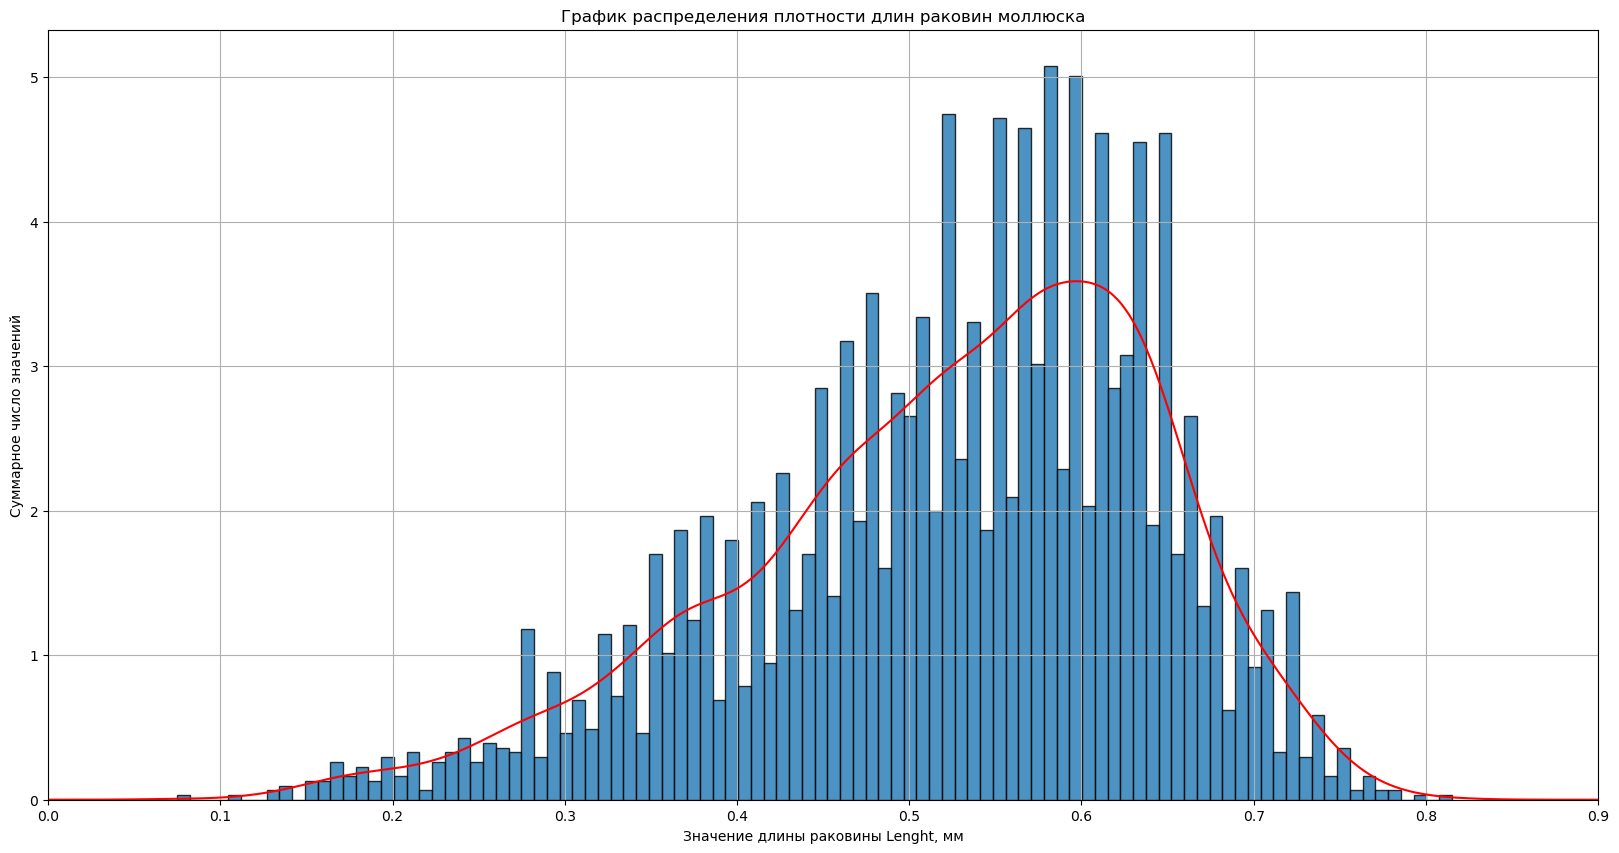

In [119]:
plt.figure(figsize=(20,10))
data['length'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    edgecolor='black'
                   )
data['length'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения плотности длин раковин моллюска')
plt.xlim(0, 0.9)
plt.xlabel('Значение длины раковины Lenght, мм')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

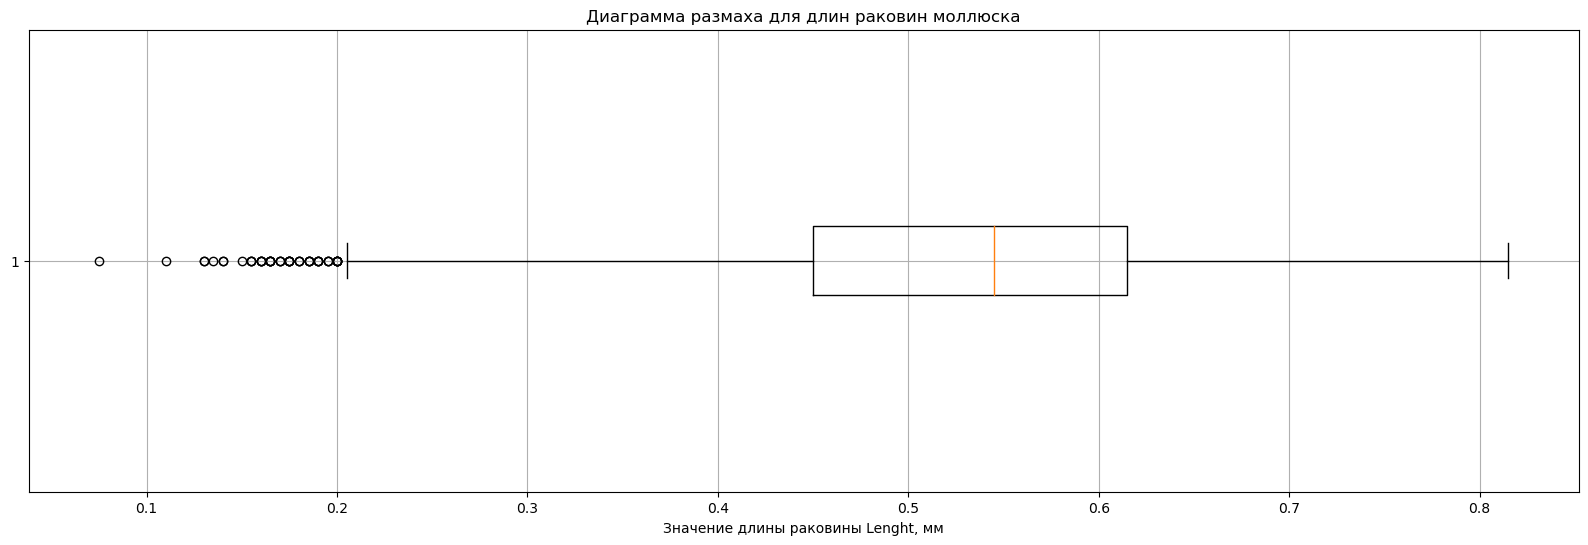

In [120]:
plt.figure(figsize=(20, 6))
plt.boxplot(data['length'], vert=False)
plt.title('Диаграмма размаха для длин раковин моллюска')
plt.xlabel('Значение длины раковины Lenght, мм')
plt.grid(True)
plt.show()

На основании построенных графиков можно сделать следующие выводы:
1. общее число моллюсков возрастает до 0.55 мм, являющегося медианным значением.
2. плотность распределения нельзя однозначно назвать равномерной. 
3. на диаграмме размаха более чётко, в отличие от гистограммы распределения плотности, наблюдаются выбросы, не попадающие в нижнюю границу. При расчёте получаем число выбросов около 1,5%. Избавимся от всех значений, менее 0,21 мм. 

In [121]:
# процент выбросов от общего числа строк в датасете
100 * len(data[data['length'] <= 0.21]) / data.shape[0]

1.4296098861158226

In [122]:
data_cl = data[data['length'] >= 0.21]

#### График плотности распределения диаметра раковин моллюска

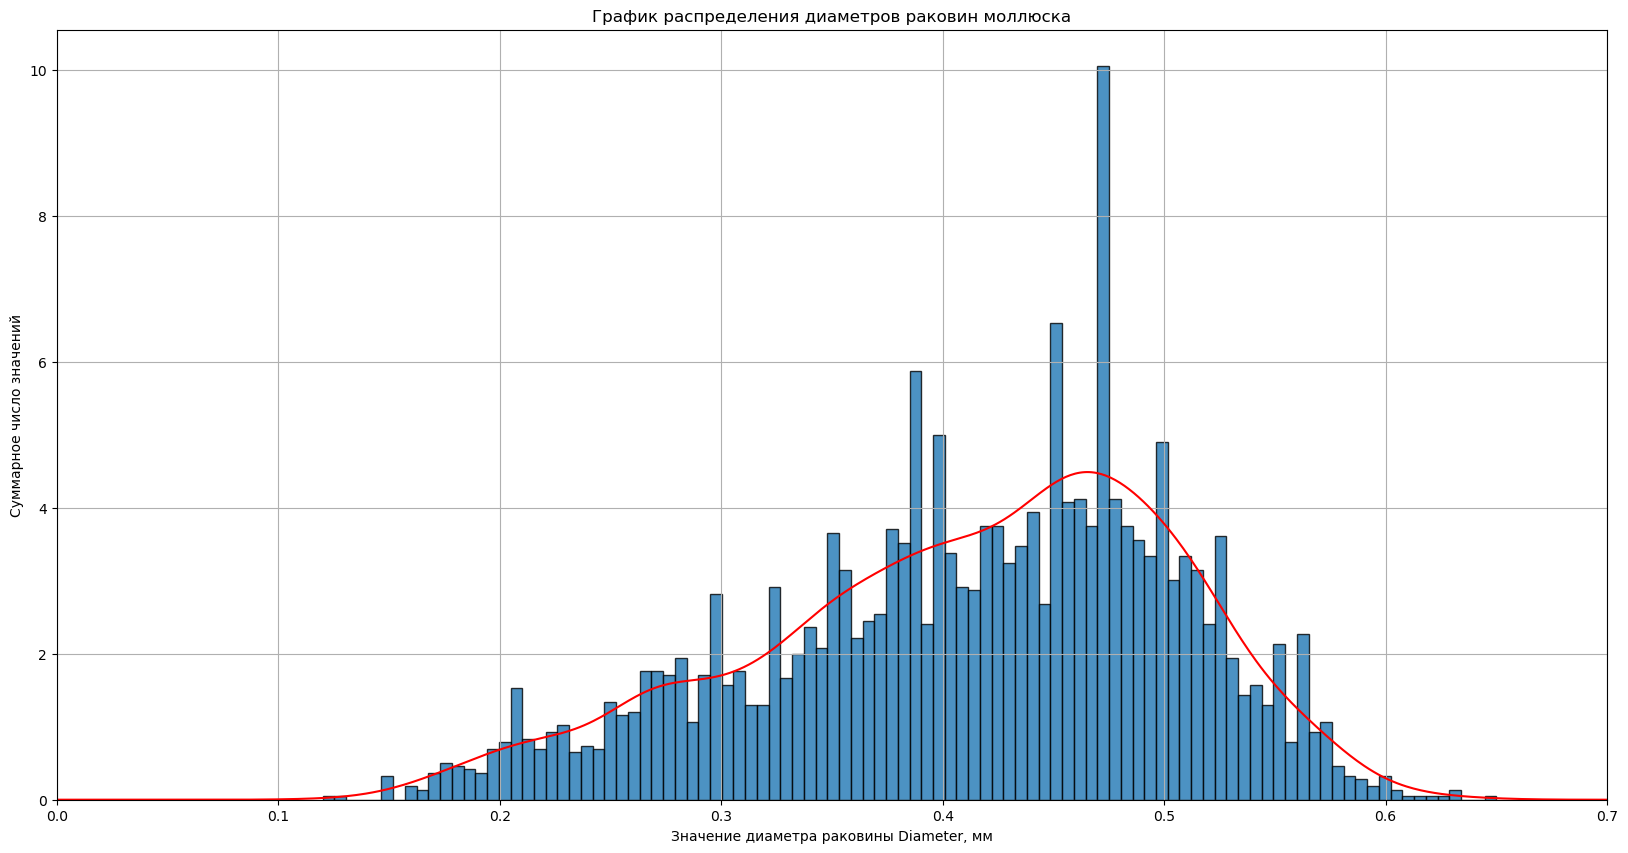

In [123]:
plt.figure(figsize=(20,10))
data_cl['diameter'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    edgecolor='black'
                   )
data_cl['diameter'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения диаметров раковин моллюска')
plt.xlim(0, 0.7)
plt.xlabel('Значение диаметра раковины Diameter, мм')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

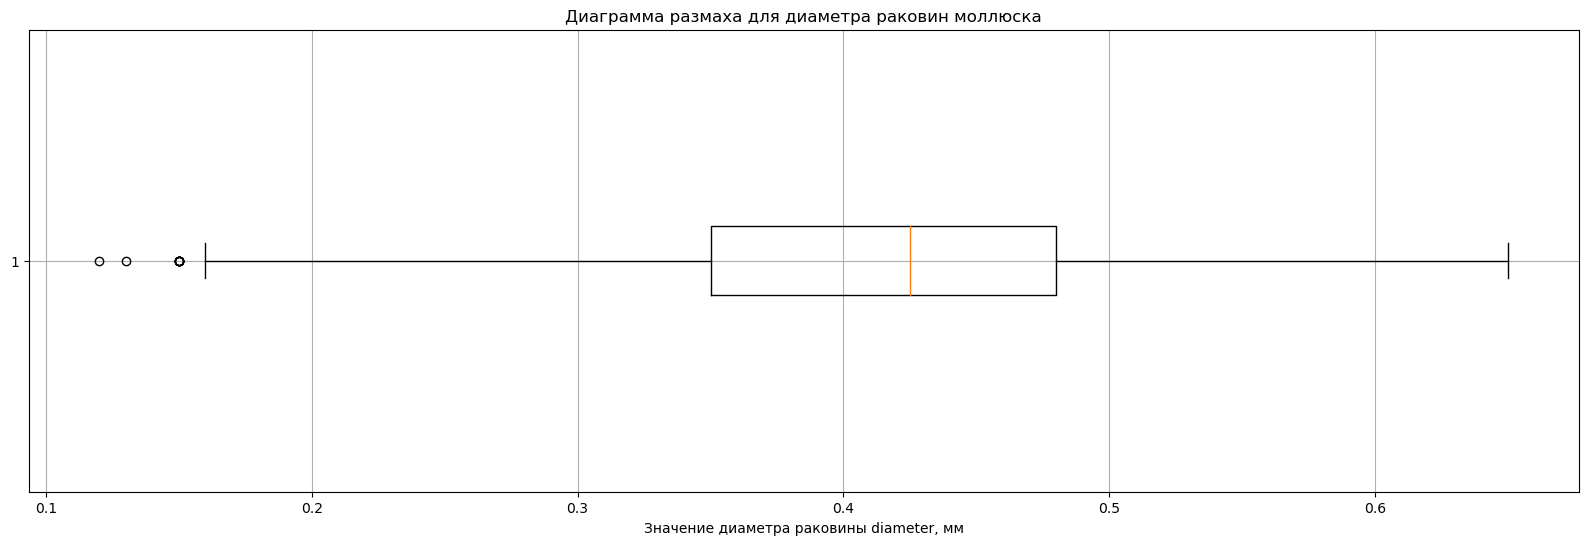

In [124]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['diameter'], vert=False)
plt.title('Диаграмма размаха для диаметра раковин моллюска')
plt.xlabel('Значение диаметра раковины diameter, мм')
plt.grid(True)
plt.show()

In [125]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[data_cl['diameter'] <= 0.155]) / data_cl.shape[0]

0.22091310751104565

Выводы:
1. плотность распределения неравномерна, однако замещение достаточно плавное.
2. число выбросов составляет даже менее полпроцента от числа строк очищаемого датасета, что можно считать хорошим результатом.

#### График плотности распределения высоты раковин моллюска

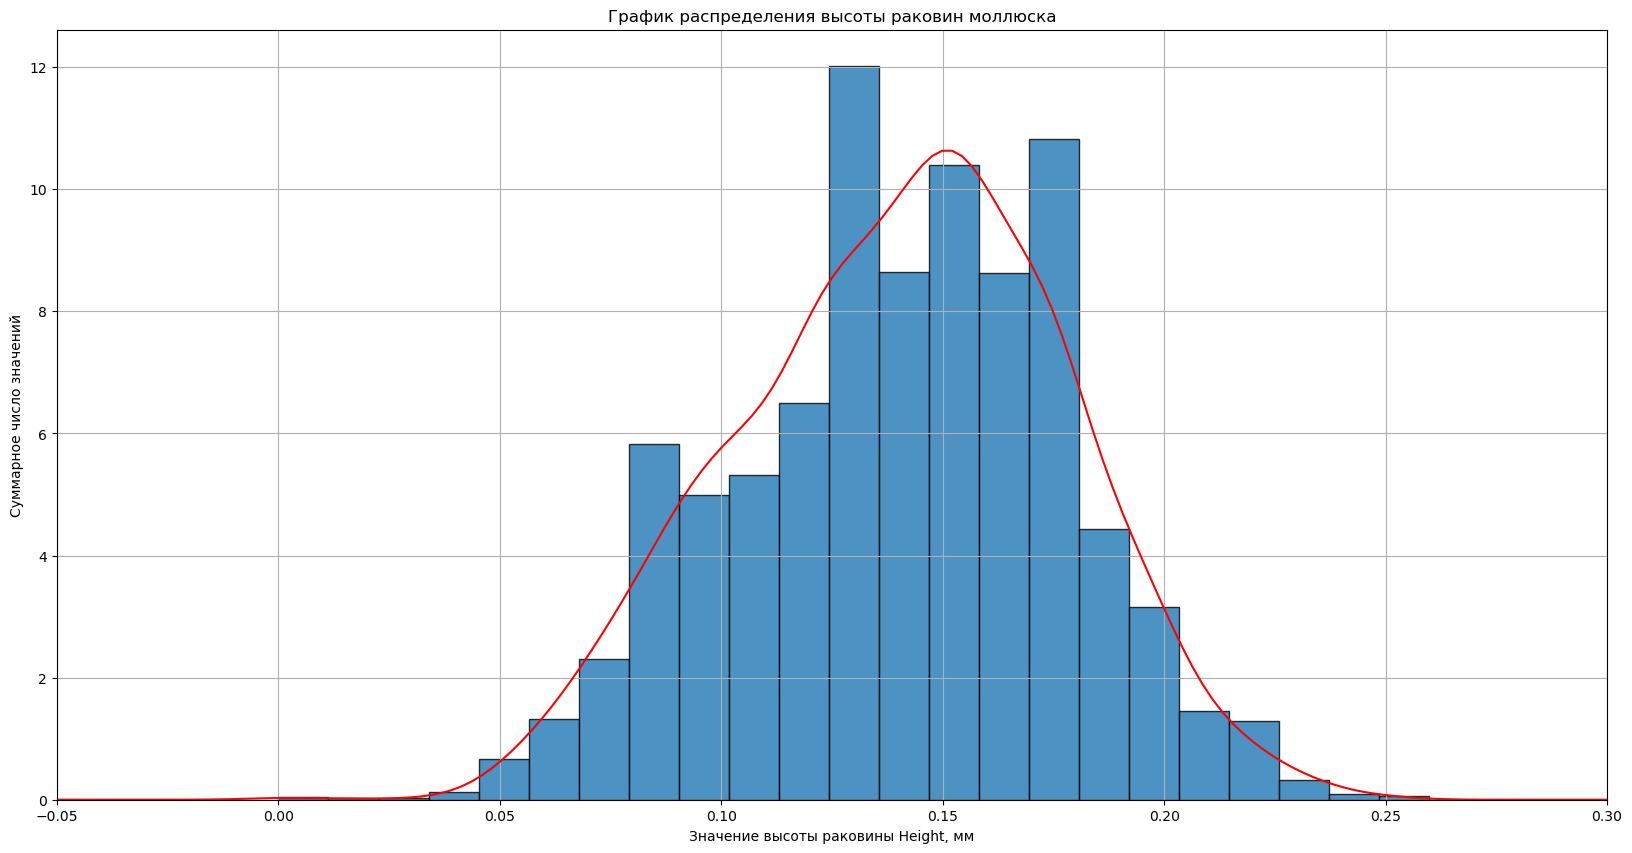

In [126]:
plt.figure(figsize=(20,10))
data_cl['height'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    edgecolor='black'
                   )
data_cl['height'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения высоты раковин моллюска')
plt.xlim(-0.05, 0.3)
plt.xlabel('Значение высоты раковины Height, мм')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

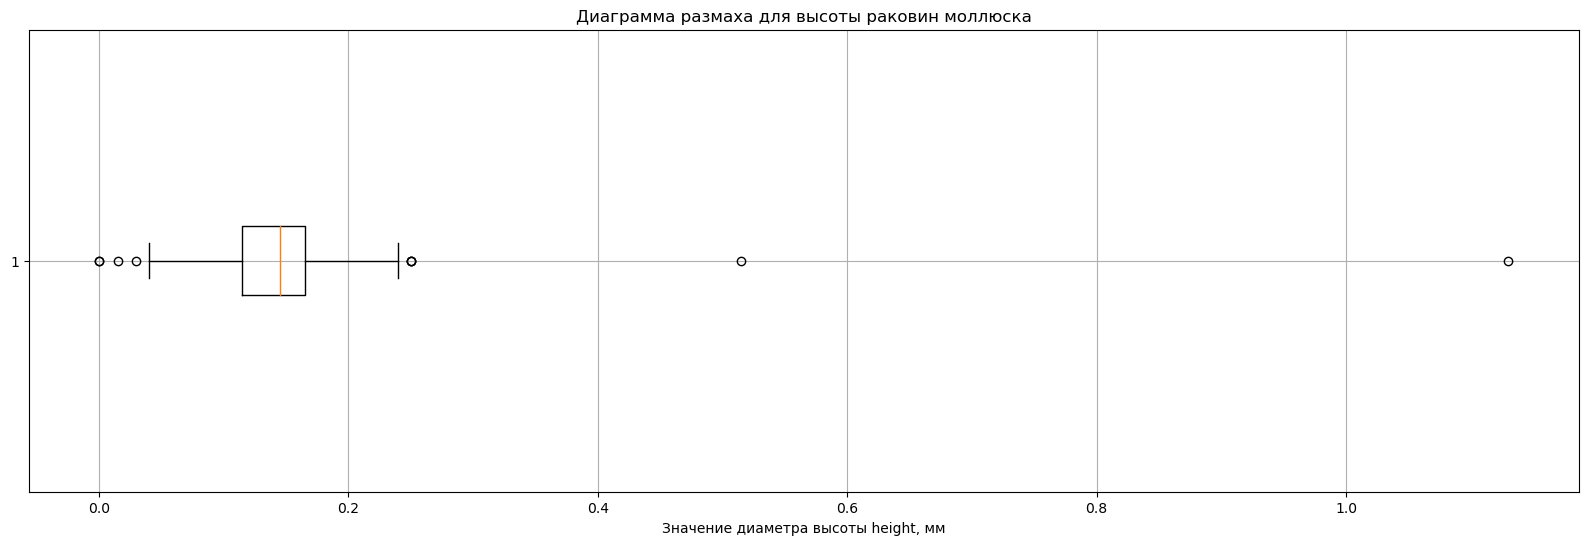

In [127]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['height'], vert=False)
plt.title('Диаграмма размаха для высоты раковин моллюска')
plt.xlabel('Значение диаметра высоты height, мм')
plt.grid(True)
plt.show()

In [128]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['height'] <= 0.025) | (data_cl['height'] > 0.24)]) / data_cl.shape[0]

0.19636720667648502

Выводы:
1. распределение более приближено к равномерному, однако существуют экстремальные выбросы. От значений более 0.4 мм имеет смысл избавиться.
2. как видно, общий число выбросов менее десятой доли процента.
3. максимальное распределение высот раковин составляет 0,15 мм.

In [129]:
data_cl = data_cl[data_cl['height'] < 0.4]

#### График плотности распределения массы целого моллюска

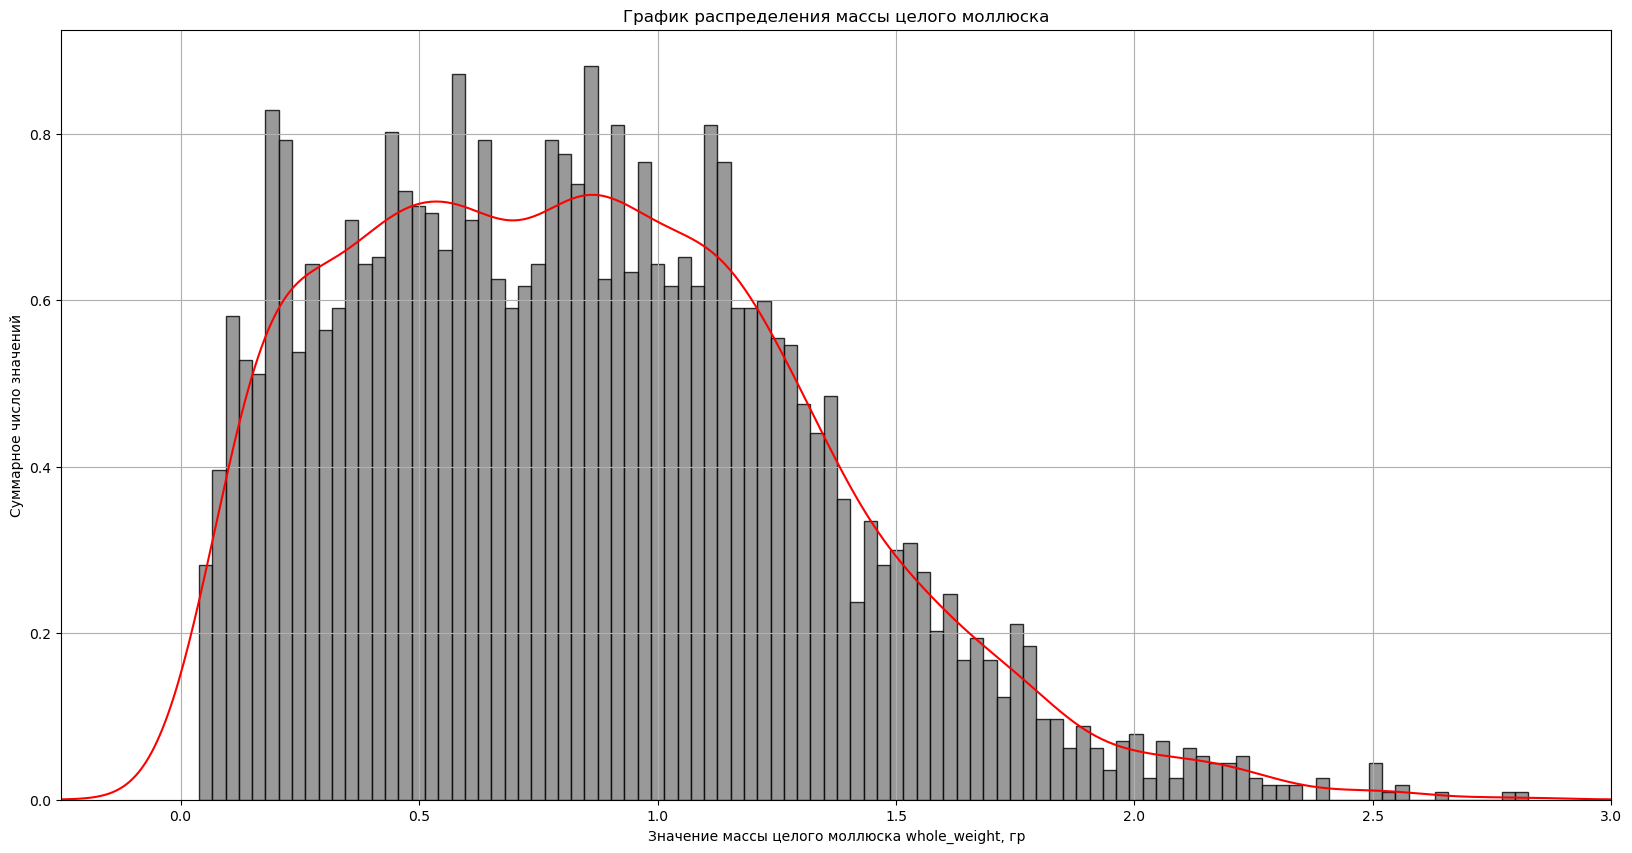

In [130]:
plt.figure(figsize=(20,10))
data_cl['whole_weight'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    color='gray',
    edgecolor='black'
                   )
data_cl['whole_weight'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения массы целого моллюска')
plt.xlim(-0.25, 3)
plt.xlabel('Значение массы целого моллюска whole_weight, гр')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

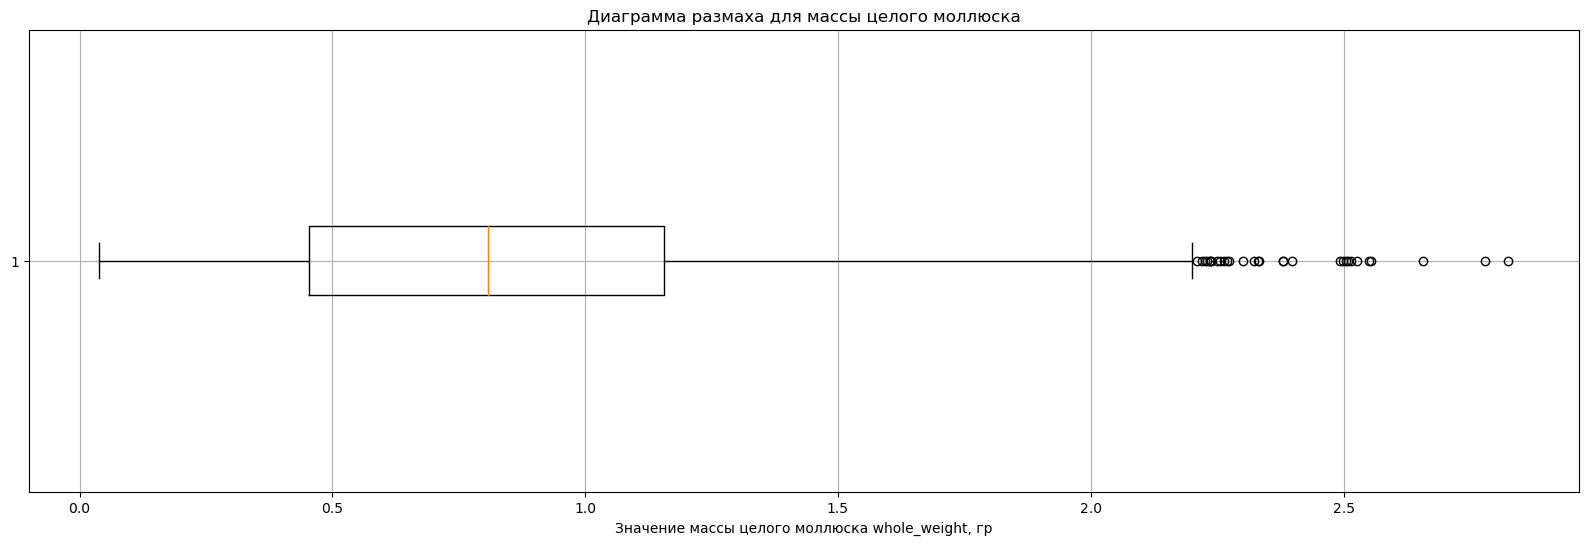

In [131]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['whole_weight'], vert=False)
plt.title('Диаграмма размаха для массы целого моллюска')
plt.xlabel('Значение массы целого моллюска whole_weight, гр')
plt.grid(True)
plt.show()

In [132]:
# Число выбросов на диаграмме размаха для массы целого моллюска
len(data_cl[(data_cl['whole_weight'] > 2.25)])

22

In [133]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['whole_weight'] > 2.25)]) / data_cl.shape[0]

0.5402750491159135

Выводы:
1. в основном, целый моллюск весит в диапазоне от половины грамма до 1,2 грамма. 
2. распределение массы целого моллюска достигает плато чуть менее 0.8 грамма, а явного экстремума визуально не наблюдается. Это говорит об однородности раковин.
3. наличие выбросов всего в полпроцента явно не критично. Так что избавимся от таких строк.

In [134]:
data_cl = data_cl[(data_cl['whole_weight'] <= 2.25)]

#### График плотности распределения массы очищенного моллюска
Масса очищенного галиотиса подразумевает только массу мяса

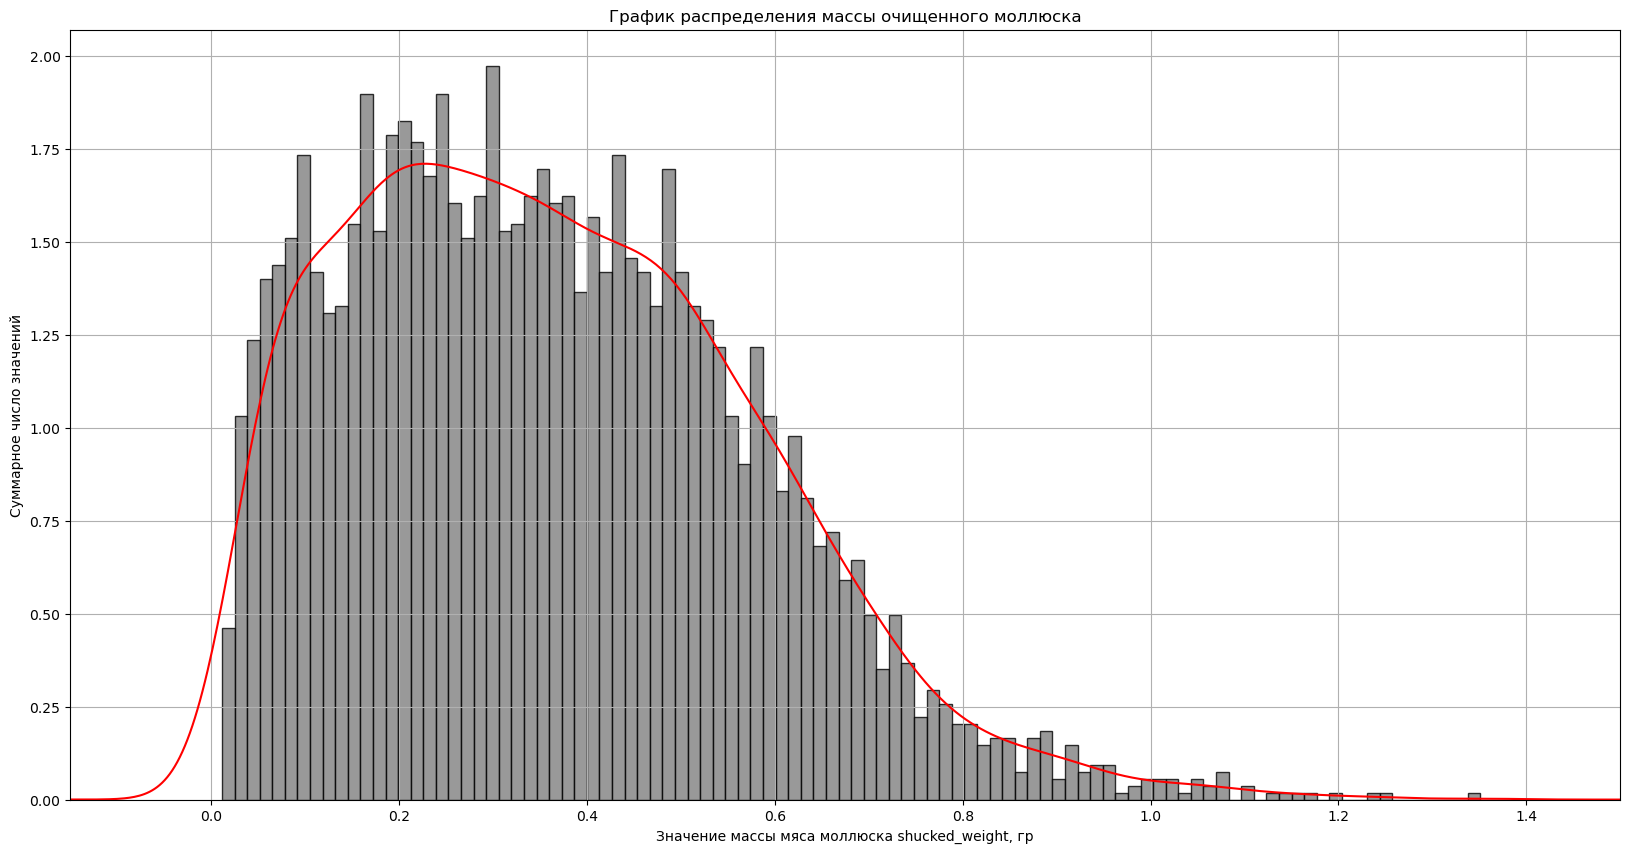

In [135]:
plt.figure(figsize=(20,10))
data_cl['shucked_weight'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    color='gray',
    edgecolor='black'
                   )
data_cl['shucked_weight'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения массы очищенного моллюска')
plt.xlim(-0.15, 1.5)
plt.xlabel('Значение массы мяса моллюска shucked_weight, гр')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

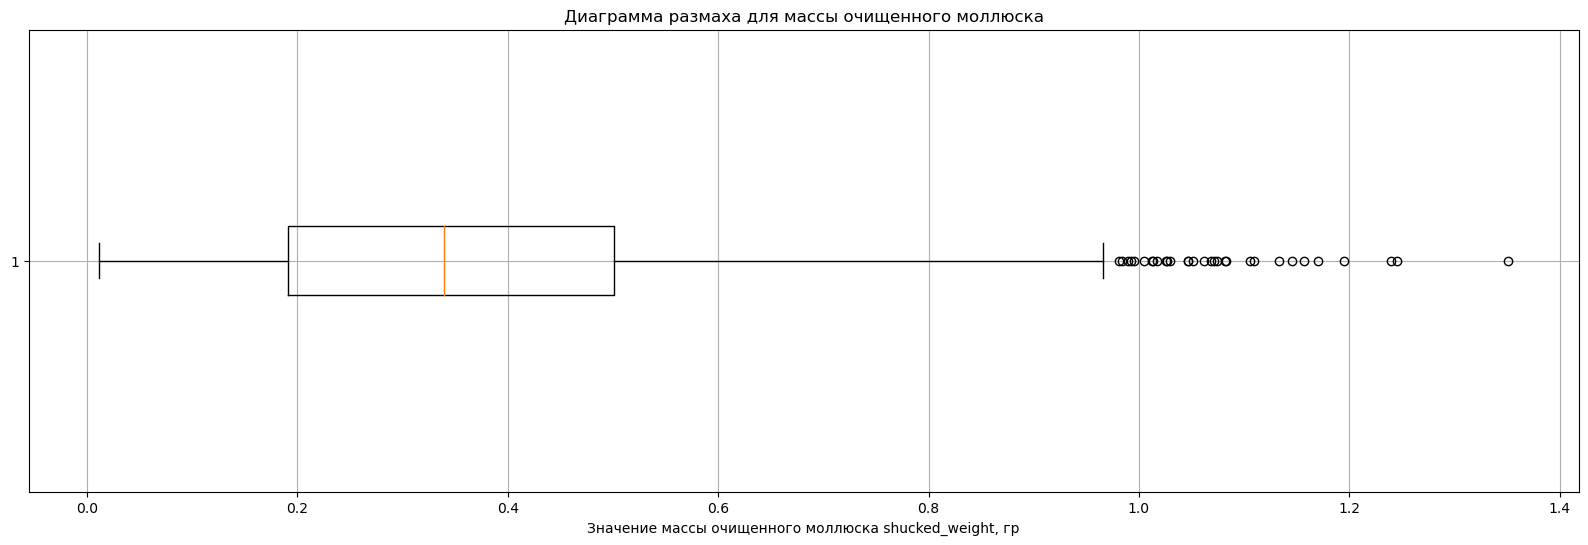

In [136]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['shucked_weight'], vert=False)
plt.title('Диаграмма размаха для массы очищенного моллюска')
plt.xlabel('Значение массы очищенного моллюска shucked_weight, гр')
plt.grid(True)
plt.show()

In [137]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['shucked_weight'] > 0.966)]) / data_cl.shape[0]

0.7654320987654321

Выводы:
1. масса очищенного моллюска составляет, в основном, от 0,2 до 0,5 грамм.
2. однако некоторые особи могут достигать массы как в 1 грамм, так и чуть более 0, что характерно для достаточно молодых моллюсков.
3. общее число выбросов, судя по диаграмме размаха составляет менее 1%.

#### График плотности распределения массы потрохов моллюска
Масса потрохов подсчитывается после обескровливания галиотиса

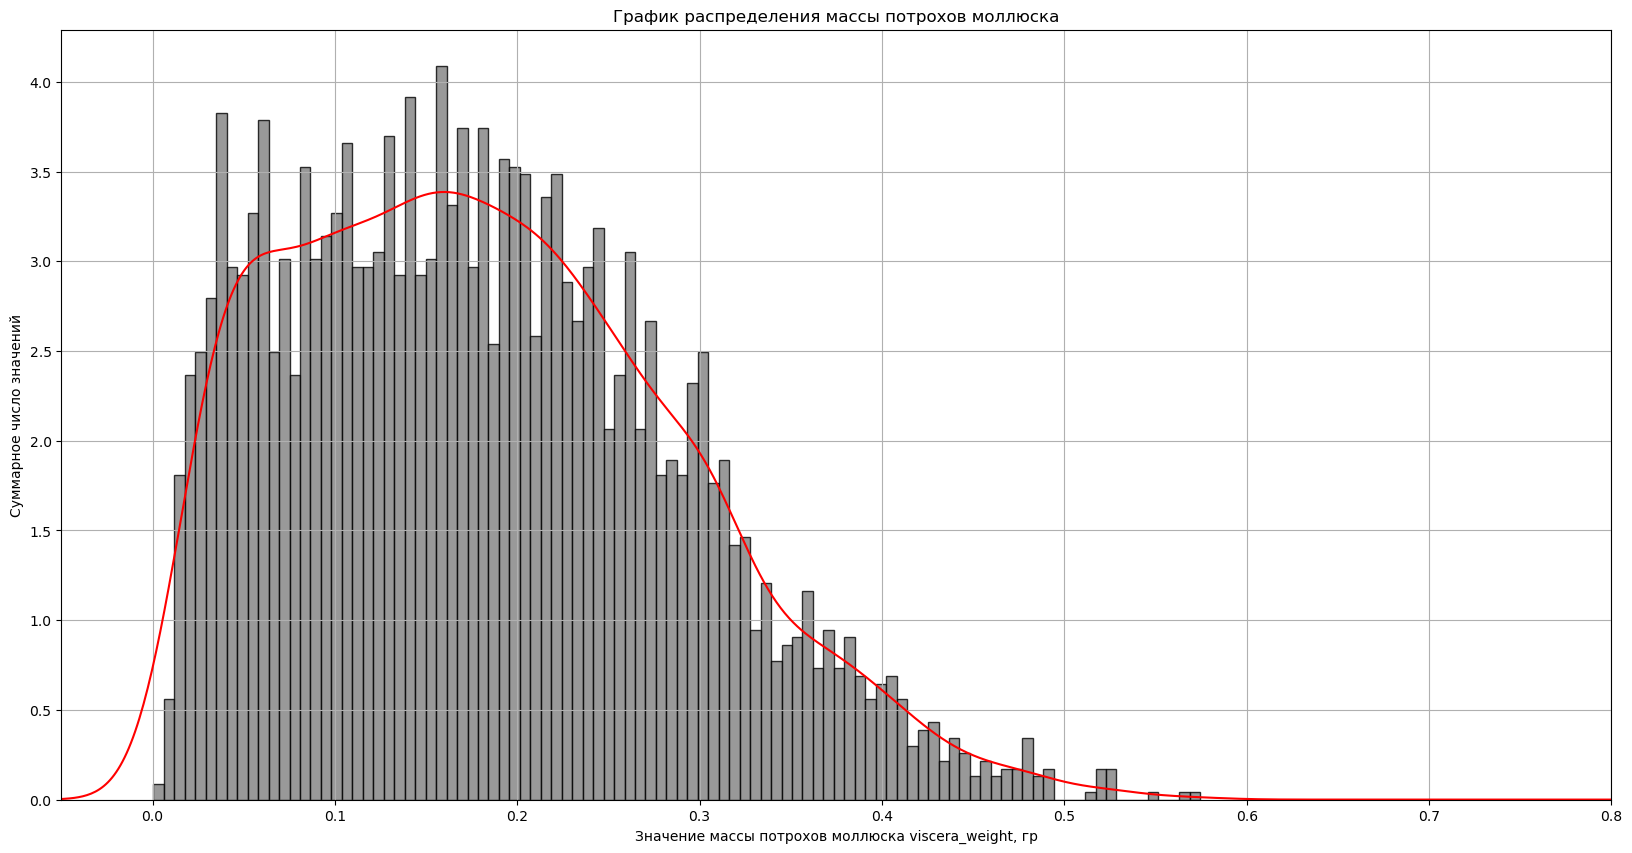

In [138]:
plt.figure(figsize=(20,10))
data_cl['viscera_weight'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    color='gray',
    edgecolor='black'
                   )
data_cl['viscera_weight'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения массы потрохов моллюска')
plt.xlim(-0.05, 0.8)
plt.xlabel('Значение массы потрохов моллюска viscera_weight, гр')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

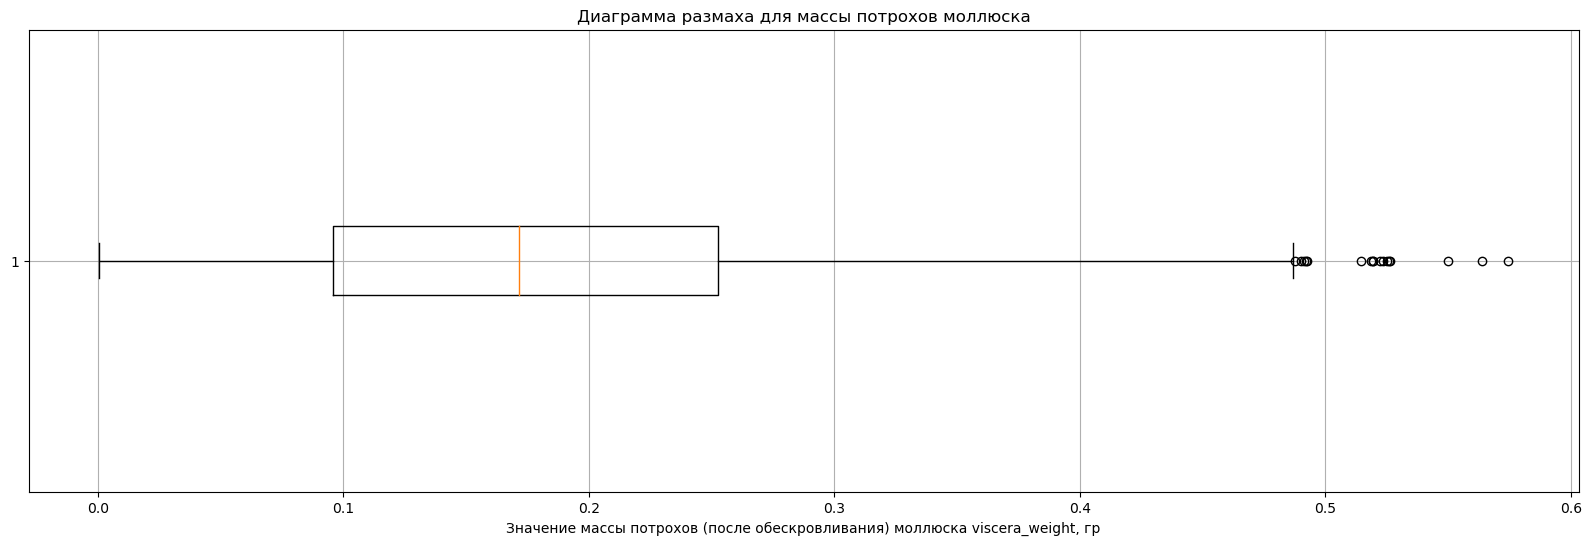

In [139]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['viscera_weight'], vert=False)
plt.title('Диаграмма размаха для массы потрохов моллюска')
plt.xlabel('Значение массы потрохов (после обескровливания) моллюска viscera_weight, гр')
plt.grid(True)
plt.show()

In [140]:
# просмотр кажущихся аномальными значений масс потрохов моллюска
# data[data['viscera_weight'] < 0.01]

In [141]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['viscera_weight'] > 0.49)]) / data_cl.shape[0]

0.37037037037037035

Выводы:
1. масса потрохов крайне мала по сравнению с другими массами. Поскольку она подсчитывается после выполнения иссушения (обескровливания) потрохов, имеем распределение, находящееся в границах от чуть выше нуля до 0,5 граммов.
2. при этом визуально достаточно сложно выделить интервал масс, характерный для данного признака, на котором демонстрируются наиболее частые результаты. Указанный выше интервал достаточно спокойно представлен.
3. как и в случае выше, имеем менее процента выбросов.

#### График плотности распределения массы скорлупы моллюска
Подразумевается масса моллюска после высушивания

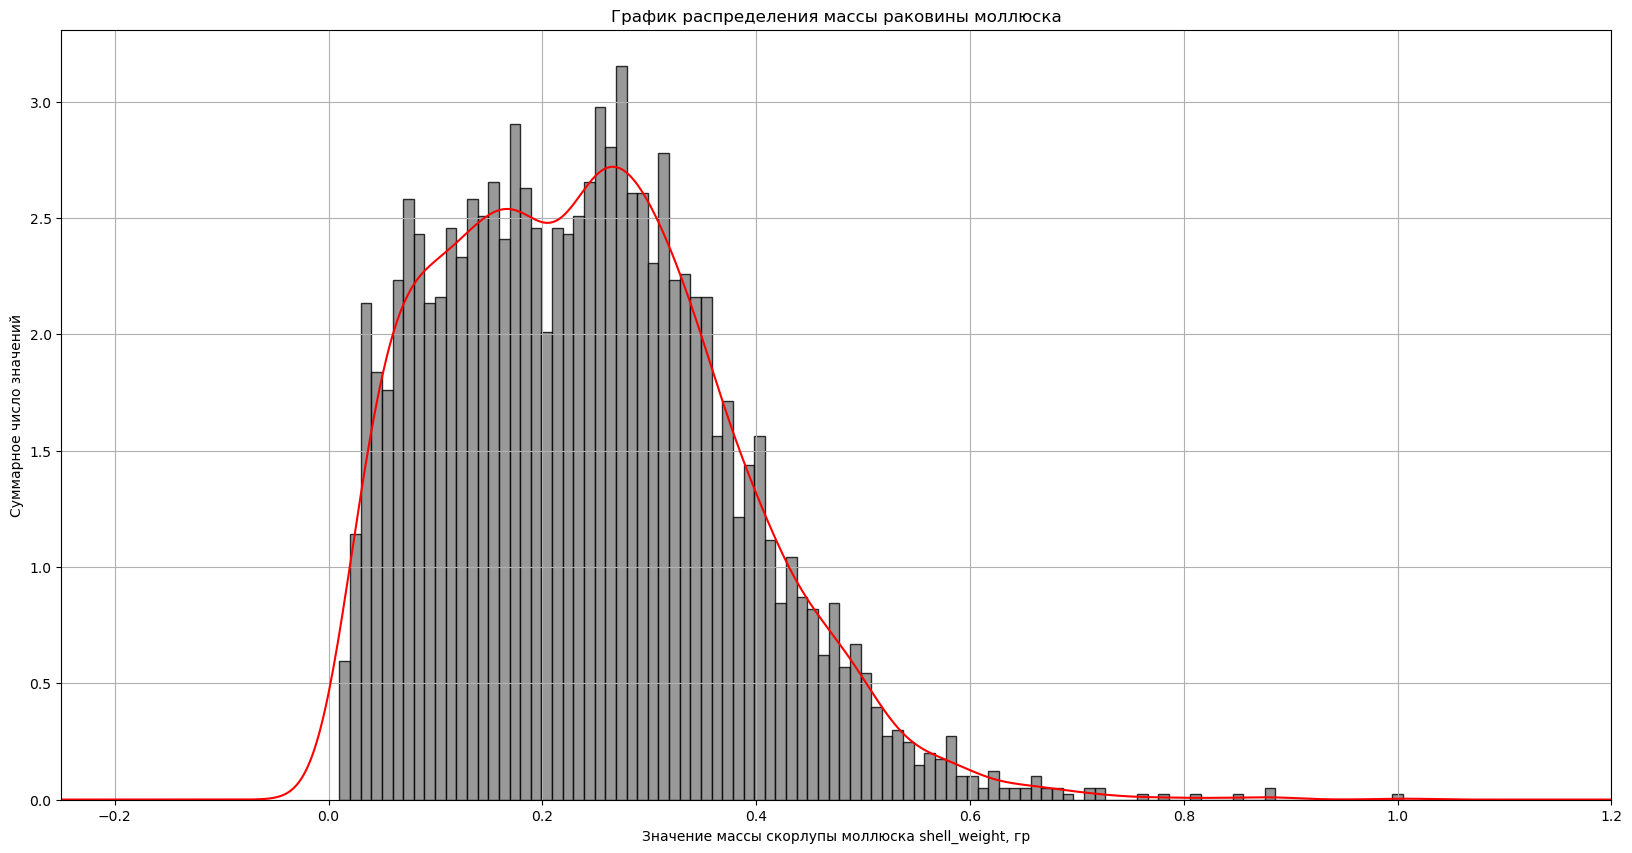

In [142]:
plt.figure(figsize=(20,10))
data_cl['shell_weight'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    color='gray',
    edgecolor='black'
                   )
data_cl['shell_weight'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения массы раковины моллюска')
plt.xlim(-0.25, 1.2)
plt.xlabel('Значение массы скорлупы моллюска shell_weight, гр')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

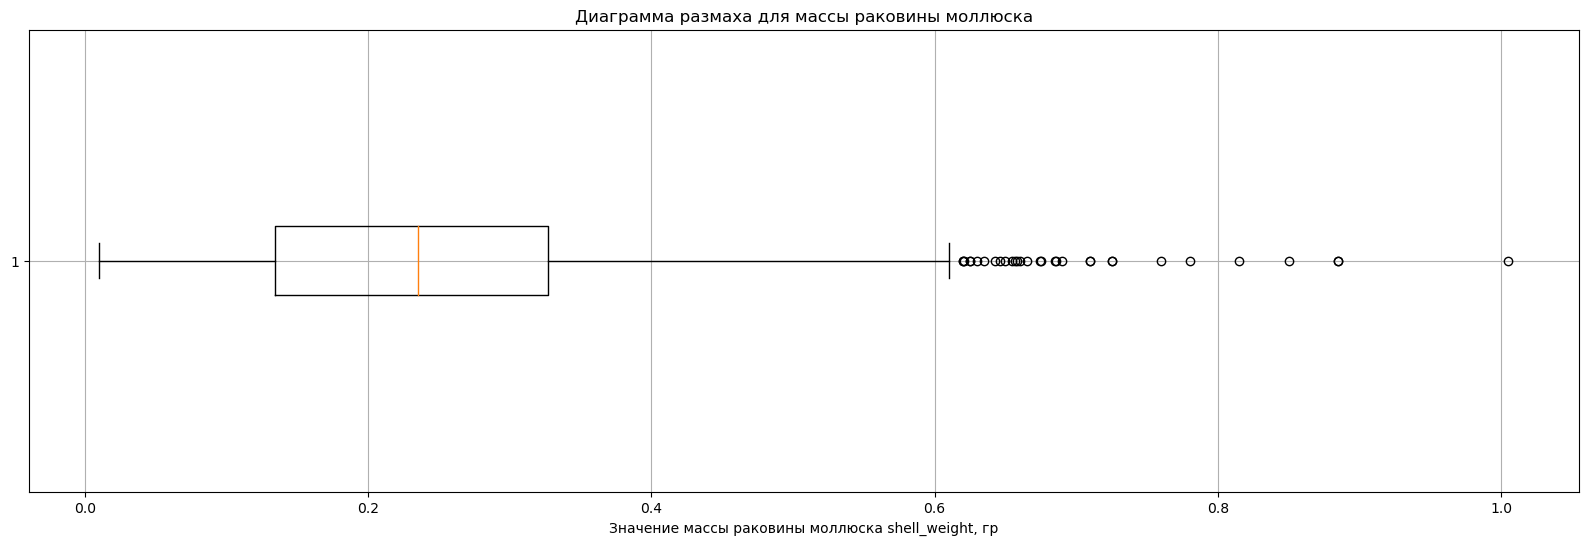

In [143]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['shell_weight'], vert=False)
plt.title('Диаграмма размаха для массы раковины моллюска')
plt.xlabel('Значение массы раковины моллюска shell_weight, гр')
plt.grid(True)
plt.show()

In [144]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['shell_weight'] >= 0.625)]) / data_cl.shape[0]

0.691358024691358

Выводы:
1. масса раковин распределяется в границах от чуть более 0 до 0,6 граммов. БОльшие значения не характерны для галиолисов.
2. наиболее часты раковины массой от 0,1 до 0,3 грамма. Выделить какие-либо экстремальные значения в данном случае не получается.
3. в данном случае число выбросов составляет менее половины десятой доли процента. И от таких выбросов можно смело избавиться, ввиду их малочисленности. 

In [145]:
data = data[(data['viscera_weight'] < 0.625)]

#### График плотности распределения колец раковин
Каждое кольцо приблизительно указывает на возраст галиотиса. Отношение: 1 кольцо соответствует приблизительно 1,5 года. Для дальнейших расчётов оперировать возрастом в годах нет необходимости, поэтому оставим подсчёт в кольцах.

In [146]:
# общее число различных колец
len_rings = len(data_cl['rings'].unique())
len_rings

26

На основании полученного результата указываем число корзин на графике плотности распределения. В отличие от иных графиков, здесь нет смысла указывать число более 29 (де-факто колец и того меньше).

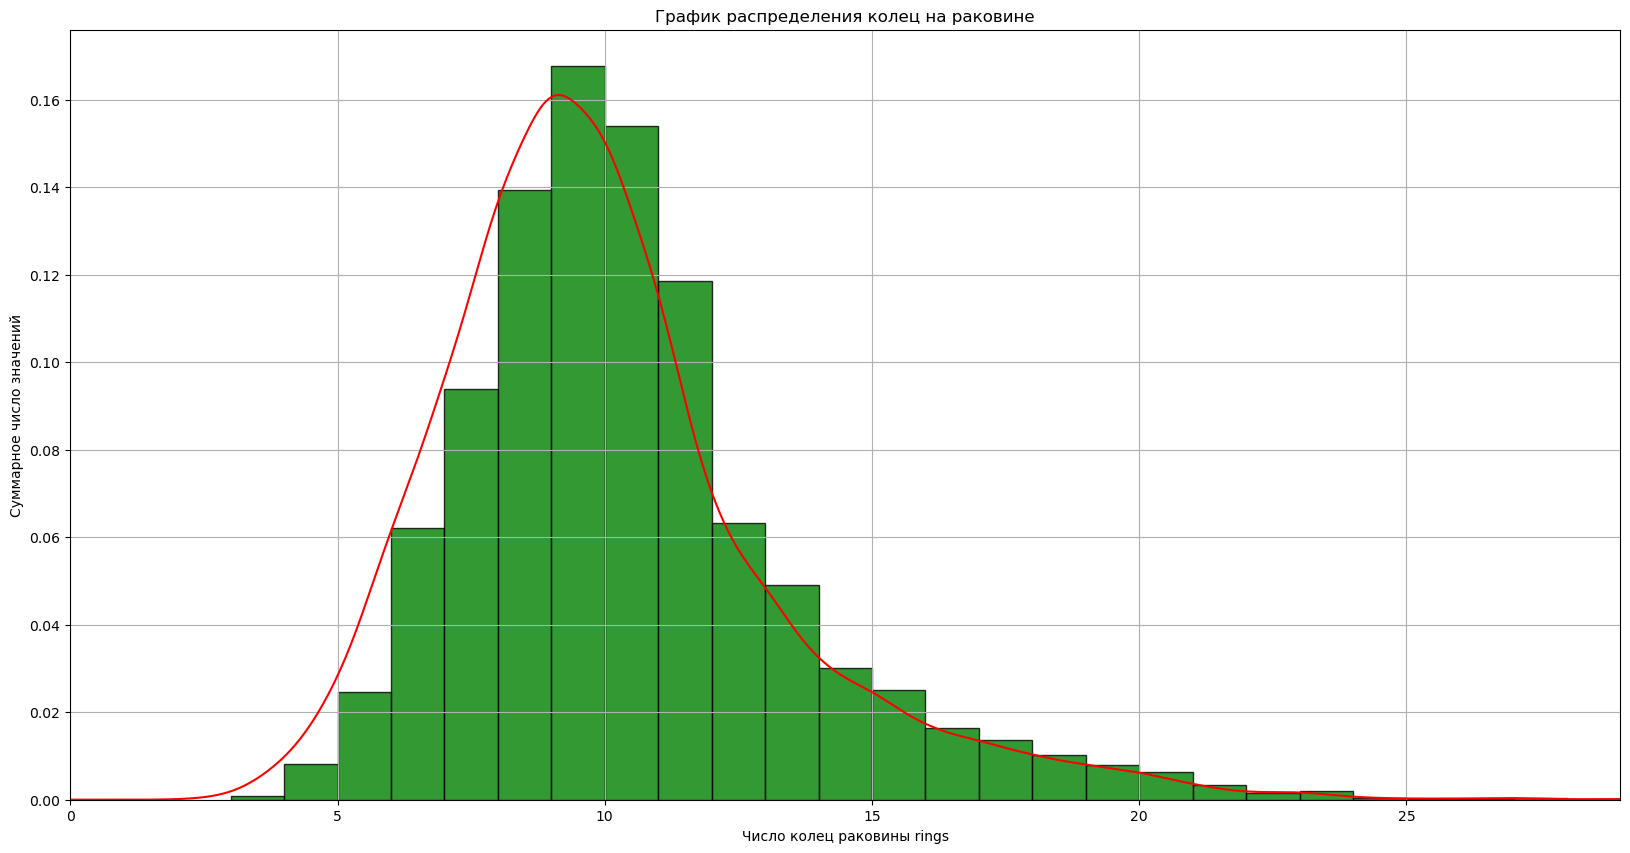

In [147]:
plt.figure(figsize=(20,10))
data_cl['rings'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=len_rings, 
    color='green',
    edgecolor='black'
                   )
data_cl['rings'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения колец на раковине')
plt.xlim(0, 29)
plt.xlabel('Число колец раковины rings')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

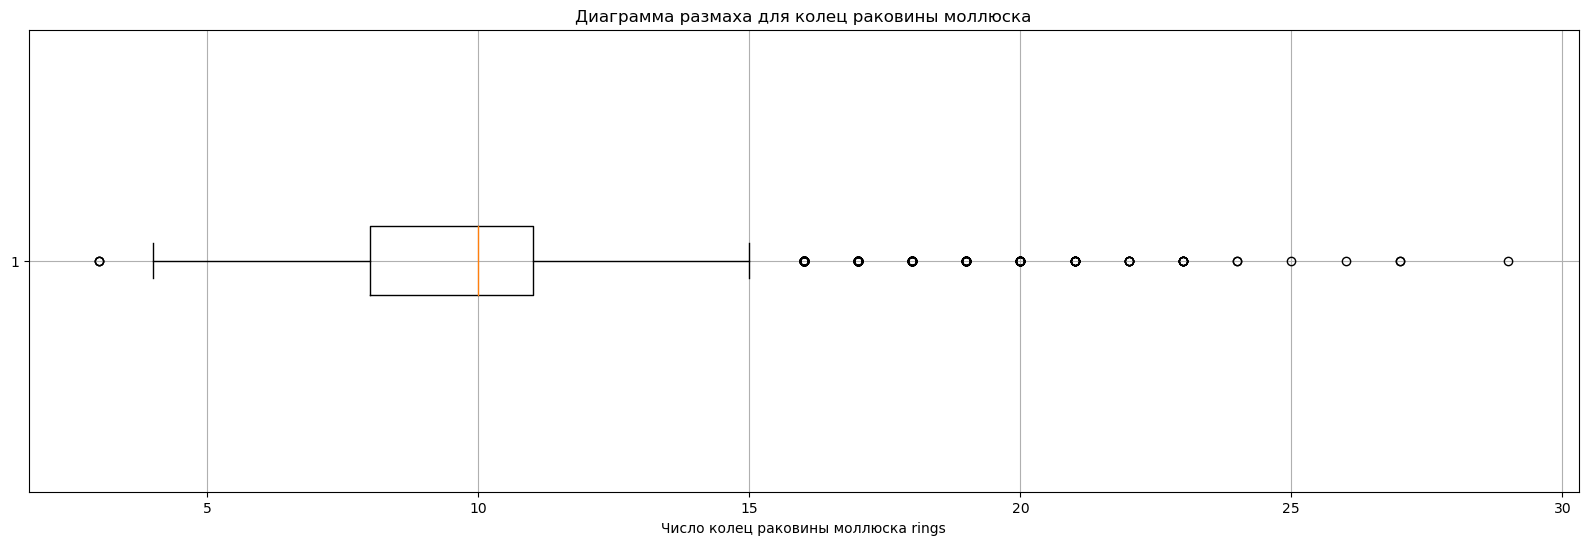

In [148]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['rings'], vert=False)
plt.title('Диаграмма размаха для колец раковины моллюска')
plt.xlabel('Число колец раковины моллюска rings')
plt.grid(True)
plt.show()

In [149]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['rings'] > 15) | (data_cl['rings'] < 4)]) / data_cl.shape[0]

6.37037037037037

Выводы:
1. распределение колец в выборке можно считать равномерным, ввиду явного возрастания и затухания графика плотности при достижении значения в 10 колец. От 8 до 11 колец наиболее часто встречаются в выборке.
2. это говорит о наличии в датасете моллюсков галиолисов в возрасте от 12 до 17 лет, которые наиболее часто встречаются среди прочих. Общий же диапазон возрастов, если судить по кольцам на раковине, составляет от 6 до 21,5 года. 
3. согласно диаграмме размаха выбросами в данном случае считаются все значения менее 4 и более 15 колец. Однако суммарно это составляет более 6% от общего числа значений очищенного датасета, ввиду чего избавляться от подобных данных не станем. 

### Выявление связи с целевой переменной

In [150]:
print(f'По результату очистки данных в ходе ИАД датасет составляет {round(100 * data_cl.shape[0] / data.shape[0], 2)}% от первоначального')
print(f'Число строк в датасете {data_cl.shape[0]}, число признаков {data_cl.shape[1]}')

По результату очистки данных в ходе ИАД датасет составляет 98.18% от первоначального
Число строк в датасете 4050, число признаков 9


Как видно, в датасете находится немногим более 4000 объектов и 9 признаков (хотя это итак указано в условиях), из которых один является целевым, а именно `rings`. Собственно говоря, число колец раковины галиолиса является единственным признаком с целочисленным типом данных. 

Для датасета выполним проверку сбалансированности таргетов для целевого признака.

In [151]:
data_cl['rings'].value_counts()

9     679
10    624
8     565
11    480
7     380
12    256
6     252
13    199
14    122
15    102
5     100
16     66
17     55
18     41
4      33
19     32
20     26
21     14
23      8
22      6
3       3
27      2
24      2
26      1
29      1
25      1
Name: rings, dtype: int64

Ввиду того, что значения не распределены примерно поровну (выявили ранее), то можно считать, что значения целевого признака не сбалансированы. Это может привести к проблемам при обучении модели в дальнейшем. Чтобы частично избавиться от подобных проблем, необходимо избавиться от явных выбивающихся значений, которые выше продемонстрированы на диаграмме размаха, т.е. избавимся от колец более 23. 

Также возможно выполнить проверку на мультиколлинеарность для исходного датасета. В результат получим матрицу корреляций между всеми столбцами (признаками) датасета. Если есть сильная корреляция между какими-то столбцами, то это может указывать на мультиколлинеарность. В таком случае можно рассмотреть возможность удаления одного из коррелирующих столбцов.

In [152]:
data_cl = data_cl[data_cl['rings'] <= 23]

## Построение матрицы корреляций

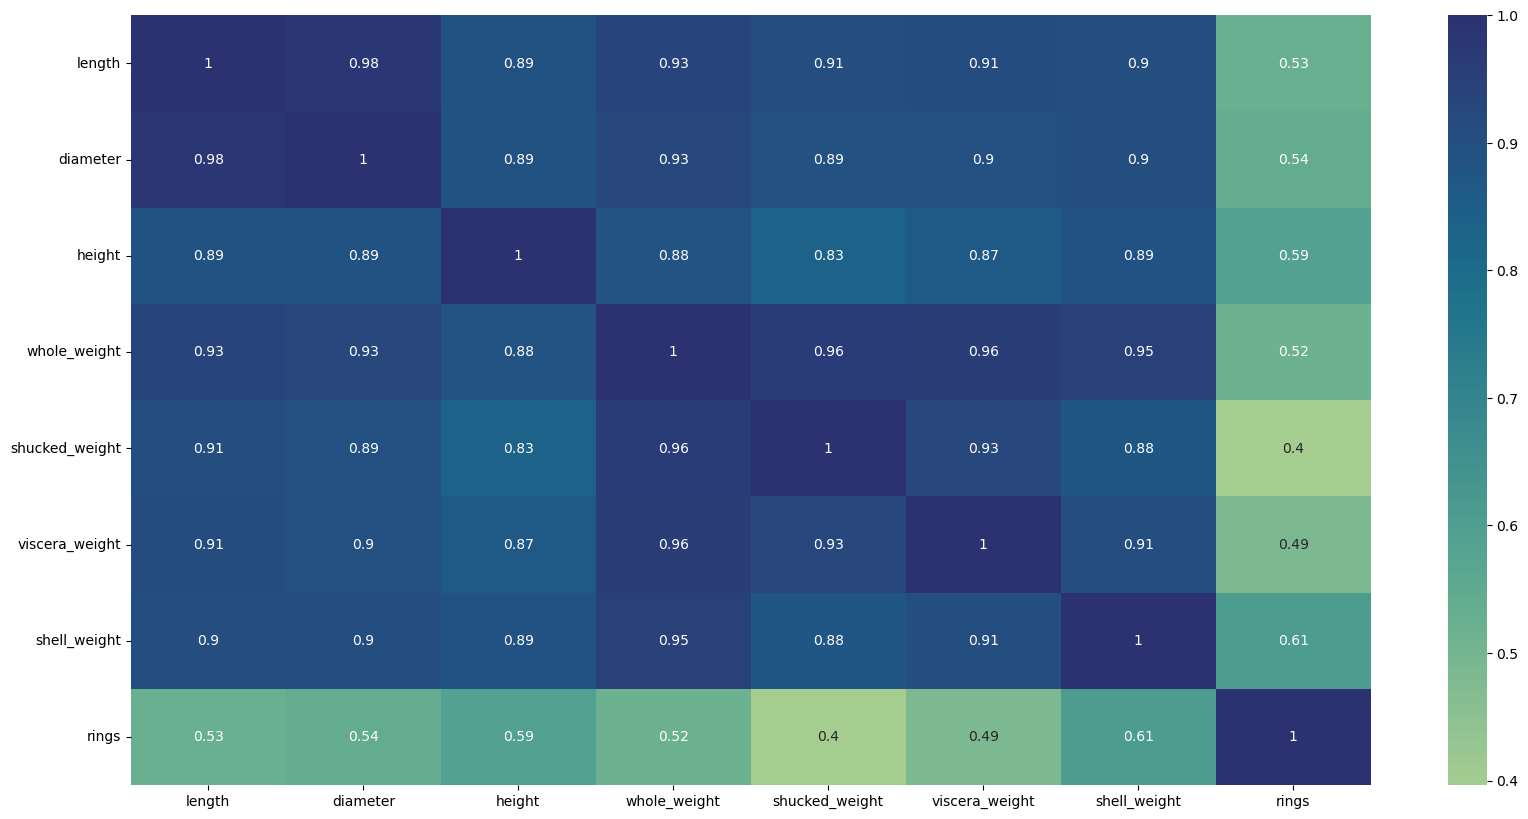

In [155]:
corr = data_cl.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="crest", annot=True)
plt.show()

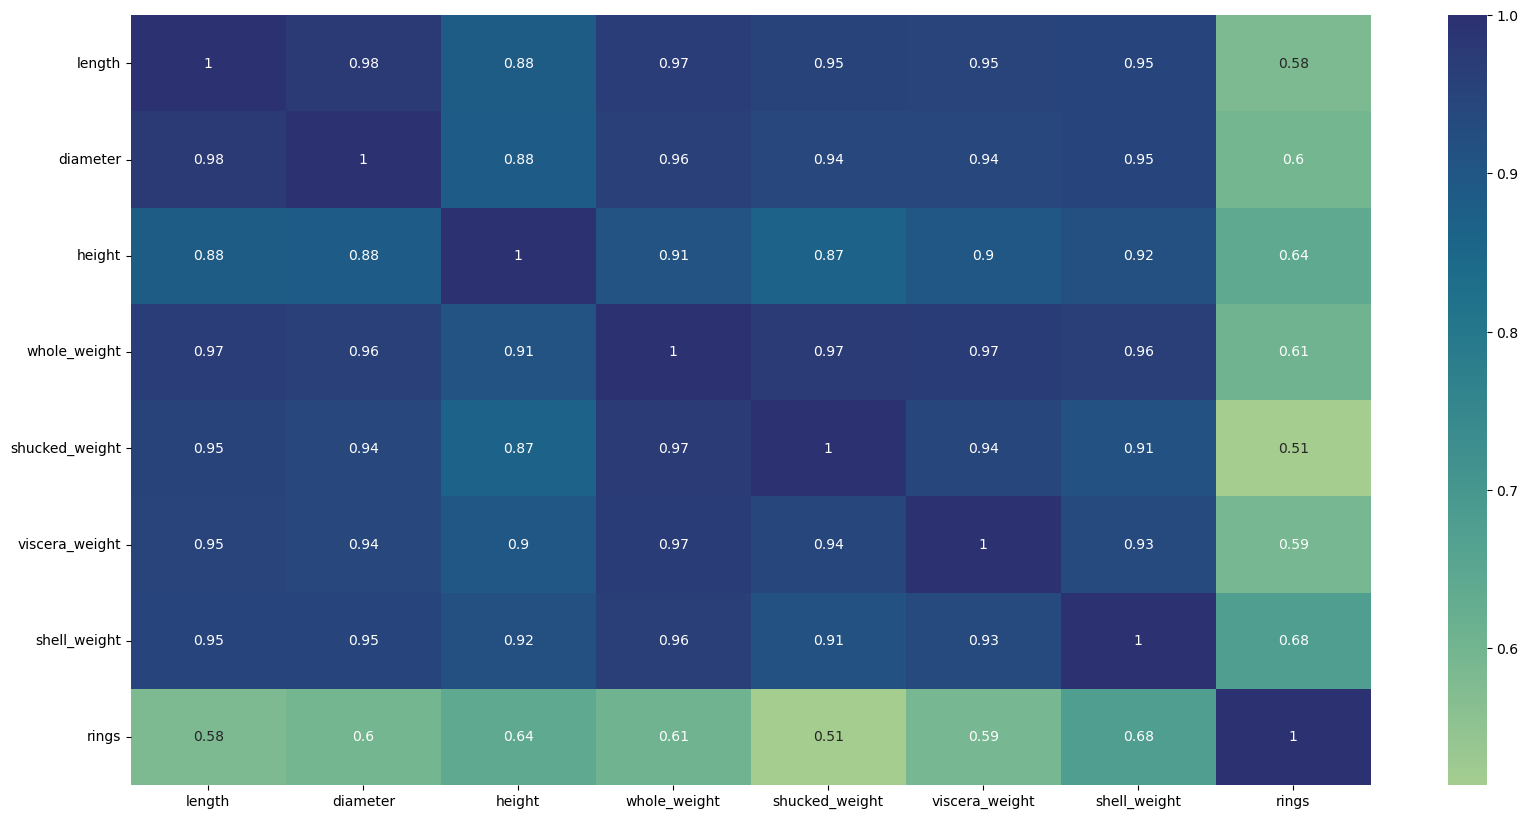

In [156]:
corr = data_cl.corr(method='spearman')
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="crest", annot=True)
plt.show()

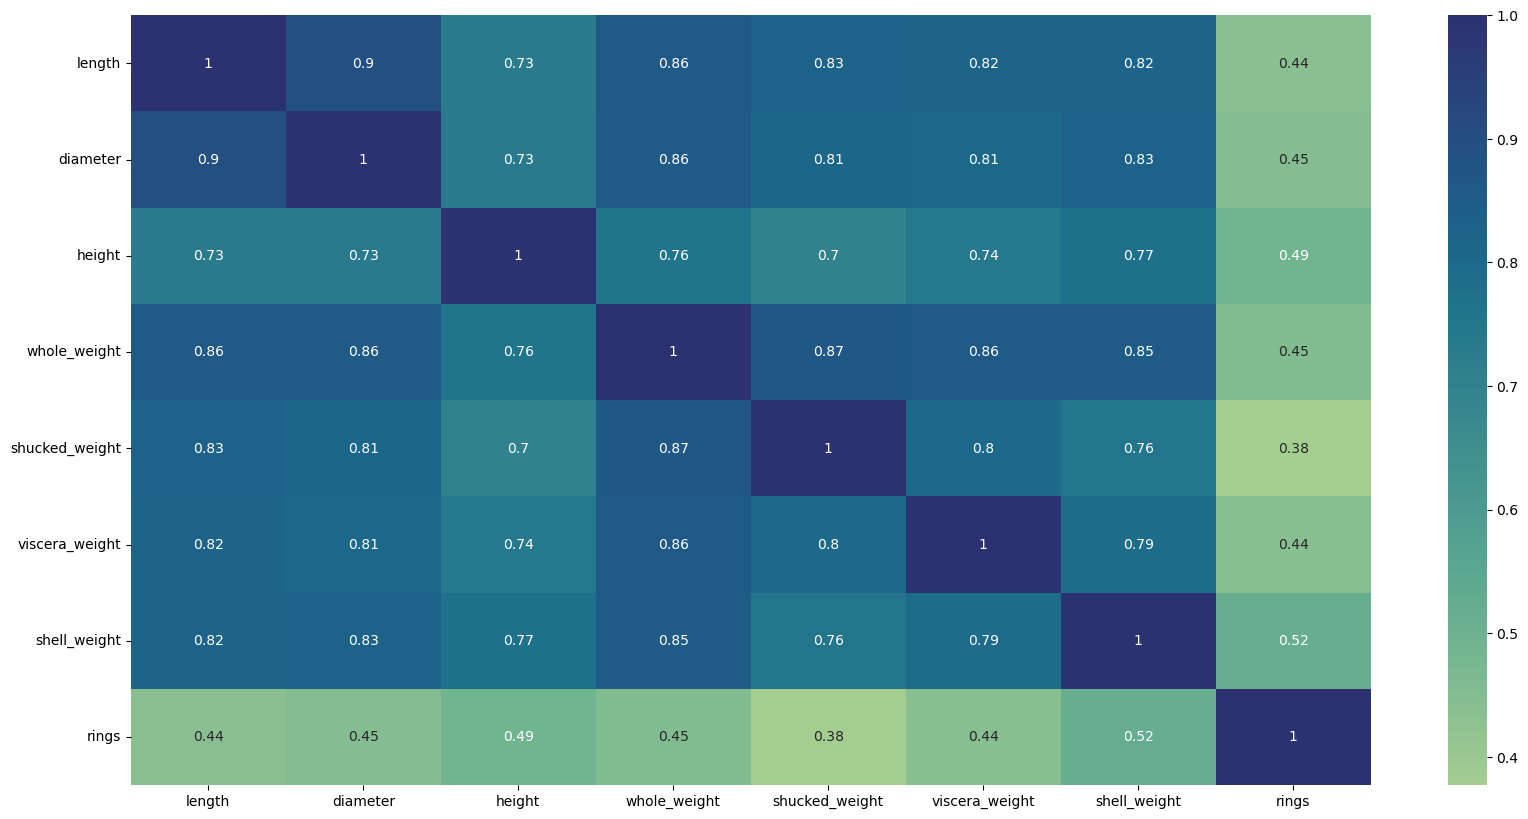

In [157]:
corr = data_cl.corr(method='kendall')
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="crest", annot=True)
plt.show()

## Анализ целевой переменной

## Сравнение библиотек

# Выводы